<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/04_transfer_learning_in_tensorflow_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture **proven to work** on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned patterns** on similar data to our own, then we can adapt those patterns to our own data.

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
TensorFlow Hub version: 0.16.1


In [36]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


##Downloading and becoming one with the data

In [37]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-05-11 10:30:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.218.207, 172.253.62.207, 172.253.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2025-05-11 10:30:47 (164 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [38]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [39]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stoppping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [40]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tesorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tesorboard_callback

## Creating models using **TensorFlow Hub**

Here, we're not going to build our model from scratch. Majority of our model's layers will coming from `TensorFlow Hub`.
We can access pretrained models on: [tensorflow.org/hub](https://www.tensorflow.org/hub)




In [41]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [42]:
# Use Keras 2.
# version_fn = getattr(tf.keras, "version", None)
# if version_fn and version_fn().startswith("3."):
#   import tf_keras as keras
# else:
#   keras = tf.keras

In [43]:
# pip install tf_keras

**Custom wrapper layer so Sequential accepts it**: Use the code from [stackoverflow](https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model) to solve the problem of Sequential accepting the layers from `resnet_url`

In [44]:
# Import the dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [45]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a URL and creates a Keras Sequential model with it
  Arguments:
    model_url(str) : Link to the model
    num_classes(int) : Number of output neurons in the output layer, should be equal to the number of target classes, default = 10
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
  """
  IMAGE_SHAPE = (224, 224)

  # Downlaod the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable = False,
                                            name = "feature_extractor_layer",
                                            input_shape = IMAGE_SHAPE + (3, )) #False in order to freeze the already learnt patterns.

  # Custom wrapper layer so Sequential accepts it
  class ResNetV2FeatureLayer(tf.keras.layers.Layer):
    def call(self, inputs):
      return feature_extraction_layer(inputs)

  # Create our own model
  model = tf.keras.Sequential([
      tf.keras.Input(shape=IMAGE_SHAPE+(3,), name="input_image"),
      ResNetV2FeatureLayer(), # Wrapped feature extractor
      layers.Dense(num_classes, activation = "softmax", name= "output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [46]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [47]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [48]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])



Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250511-103057
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 519s 22s/step - accuracy: 0.2179 - loss: 2.3120 - val_accuracy: 0.6076 - val_loss: 1.2343
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 560s 24s/step - accuracy: 0.7202 - loss: 0.9480 - val_accuracy: 0.7244 - val_loss: 0.8604
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 509s 22s/step - accuracy: 0.8247 - loss: 0.6367 - val_accuracy: 0.7368 - val_loss: 0.7944
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 508s 22s/step - accuracy: 0.8605 - loss: 0.4934 - val_accuracy: 0.7676 - val_loss: 0.7267
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 613s 24s/step - accuracy: 0.9364 - loss: 0.3547 - val_accuracy: 0.7836 - val_loss: 0.6858


In [49]:
resnet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_v2_feature_layer_2      │ (None, 2048)           │             0 │
│ (ResNetV2FeatureLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,472 (240.13 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,982 (160.09 KB)

Our transfer learning feature extractor model out performed all of the previous models we build by hand. And with only 10% of the training examples.

Tidbit: we could put a function like this into a script called "helper.py" and import it when it needed.

In [50]:
# Let's create a function to plot loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

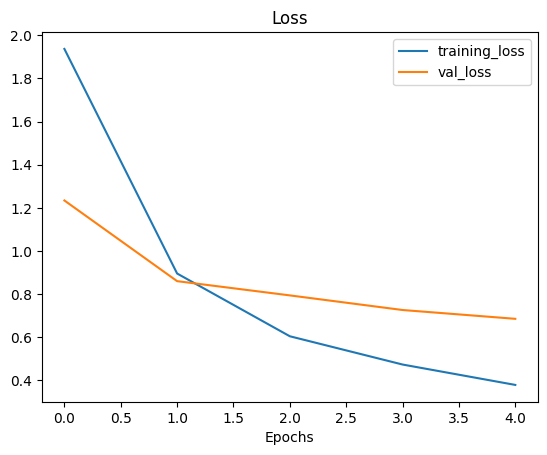

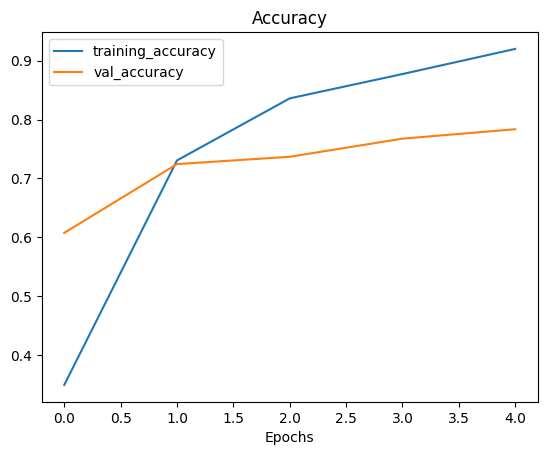

In [51]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [57]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20250511-113923
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 231s 9s/step - accuracy: 0.3514 - loss: 1.9829 - val_accuracy: 0.7492 - val_loss: 0.8409
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 212s 9s/step - accuracy: 0.7975 - loss: 0.6659 - val_accuracy: 0.8548 - val_loss: 0.4743
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 0.9177 - loss: 0.3138 - val_accuracy: 0.8508 - val_loss: 0.4548
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 212s 9s/step - accuracy: 0.9664 - loss: 0.1682 - val_accuracy: 0.8552 - val_loss: 0.4201
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 264s 9s/step - accuracy: 0.9937 - loss: 0.0918 - val_accuracy: 0.8588 - val_loss: 0.4141


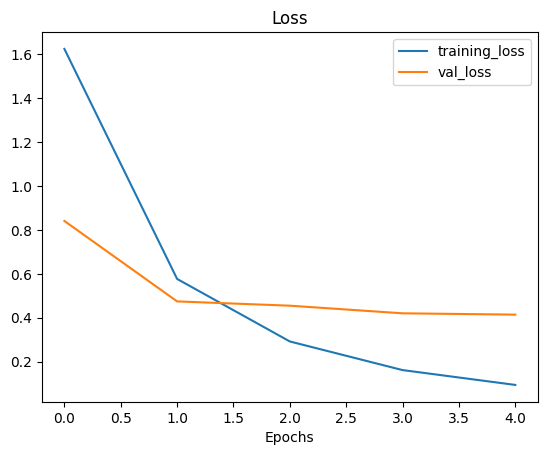

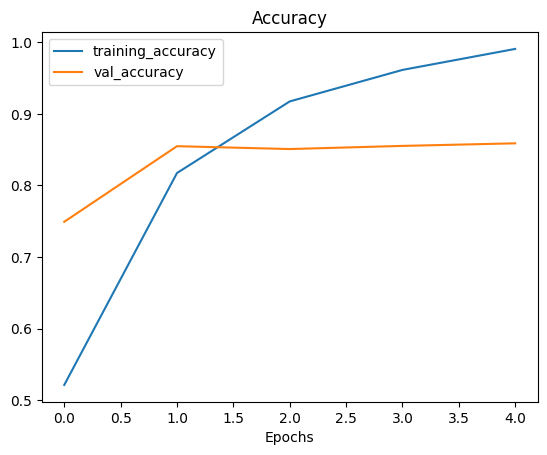

In [58]:
plot_loss_curves(efficientnet_history)

In [60]:
efficientnet_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_feature_extractor_3     │ (None, 1280)           │             0 │
│ (ResNetFeatureExtractor)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,624 (1.98 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 345,750 (1.32 MB)

In [62]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# EXTRA: Code for import through applications

In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained ResNet50 model, excluding the top (classification) layer
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze ResNet layers to prevent them from being trained
for layer in resnet_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add ResNet as the first layer
model.add(resnet_model)

# Add Flatten layer to convert ResNet output to a 1D vector
model.add(Flatten())

# Add Dense layers for classification or other tasks
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Example: 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,280,650 (187.99 MB)

 Trainable params: 25,692,938 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [53]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Print versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("TF Hub version:", hub.__version__)

# Constants
IMAGE_SHAPE = (224, 224)

# Wrapper Layer for TF Hub
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=False, name="hub_layer", **kwargs):
        super().__init__(name=name, **kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Function to create the model
def create_model(model_url, num_classes=10):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=IMAGE_SHAPE + (3,), name="input_image"),
        HubLayerWrapper(model_url, trainable=False, name="feature_extractor"),
        layers.Dense(num_classes, activation='softmax', name="output_layer")
    ])
    return model

# Example usage
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Show model summary
model.summary()


TensorFlow version: 2.18.0
Keras version: 3.8.0
TF Hub version: 0.16.1


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor               │ (None, 2048)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
import tensorflow_hub as hub
import tf_keras as keras
from tf_keras import layers

# Define image input shape
IMAGE_SHAPE = (224, 224)

# TF Hub link for ResNetV2
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Load feature extractor layer from TensorFlow Hub
resnet_feature_extractor = hub.KerasLayer(resnet_url,
                                          input_shape=IMAGE_SHAPE + (3,),
                                          trainable=False,
                                          name="resnet_v2_feature_extractor")

# Wrap it in a custom layer for Sequential compatibility
class ResNetV2FeatureLayer(layers.Layer):
    def call(self, inputs):
        return resnet_feature_extractor(inputs)

# Define the model
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3), name="input_image"),
    ResNetV2FeatureLayer(),  # Custom wrapper layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax', name='output')  # 10-class classification
])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_v2_feature_layer_1  (None, 2048)              0         
  (ResNetV2FeatureLayer)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 271178 (1.03 MB)
Trainable params: 271178 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Define a custom layer that wraps the TensorFlow Hub KerasLayer
class ResNetFeatureExtractor(layers.Layer):
    def __init__(self, model_url, **kwargs):
        super(ResNetFeatureExtractor, self).__init__(**kwargs)
        self.feature_extractor = hub.KerasLayer(
            model_url,
            trainable=False,
            name="resnet_feature_extractor"
        )

    def call(self, inputs):
        return self.feature_extractor(inputs)

# Define the model
def create_model(model_url, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(224, 224, 3), name='input_image'),
        ResNetFeatureExtractor(model_url),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

# Example usage
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
num_classes = 10  # Replace with the actual number of classes in your dataset
model = create_model(resnet_url, num_classes)

# Display the model summary
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_feature_extractor_1     │ (None, 2048)           │             0 │
│ (ResNetFeatureExtractor)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,178 (1.03 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 0 (0.00 B)